In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
2.8.0-rc1


In [2]:
# Load data
df = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
investment_ids = list(range(max(df['investment_id'].to_list())+1))
# investment_timesteps_count = [len(df.loc[df['investment_id'].values == i]) for i in investment_ids]
# print(f'Longest ID: {investment_ids[investment_timesteps_count.index(max(investment_timesteps_count))]}')
split_investments = []
for i in investment_ids:
    investment = df.loc[df['investment_id'].values == i]
    if not investment.empty:
        split_investments.append(investment)
train = split_investments[:int(len(split_investments)*0.8)]
val = split_investments[int(len(split_investments)*0.8):]
print(f'Total valid investments: {len(split_investments)}, train/val split: {len(train)}/{len(val)}')

investment_ids = list(df['investment_id'].unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids": investment_ids}))

Total valid investments: 2329, train/val split: 1863/466


In [3]:
# Pearson correlation coefficient loss and metrics
def pearson_corr(x, y, axis=-1):
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.math.abs(corr)  # by right should not be abs but in this case we just want the line to fit so it doesnt matter if its going up or down


def pearson_corr_loss(x, y, axis=-1):
    return 1 - pearson_corr(x, y, axis=axis)


# y_true = tf.cast(split_investments[0]['target'].to_numpy(), dtype=tf.float16)
#
# # t1,t2 = tf.constant([[1.], [2.], [3.], [4.], [5.]]), tf.constant([[10.], [9.], [2.5], [6.], [4.]])
# print(pearson_corr(y_true, y_pred, axis=-2))
# print(pearson_corr_loss(y_true, y_pred, axis=-2))
#
# from scipy.stats import pearsonr
# pearsonr(y_true.numpy(), y_pred.numpy())[0]  # should be same as pearson_corr
#
# y_true.numpy()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feature_in (InputLayer)        [(None, None, 300)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 128)    219648      ['feature_in[0][0]']             
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 256)    394240      ['lstm[0][0]']                   
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 256)   512         ['lstm_1[0][0]']                 
 alization)                                                                                   

C:\Program Files\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


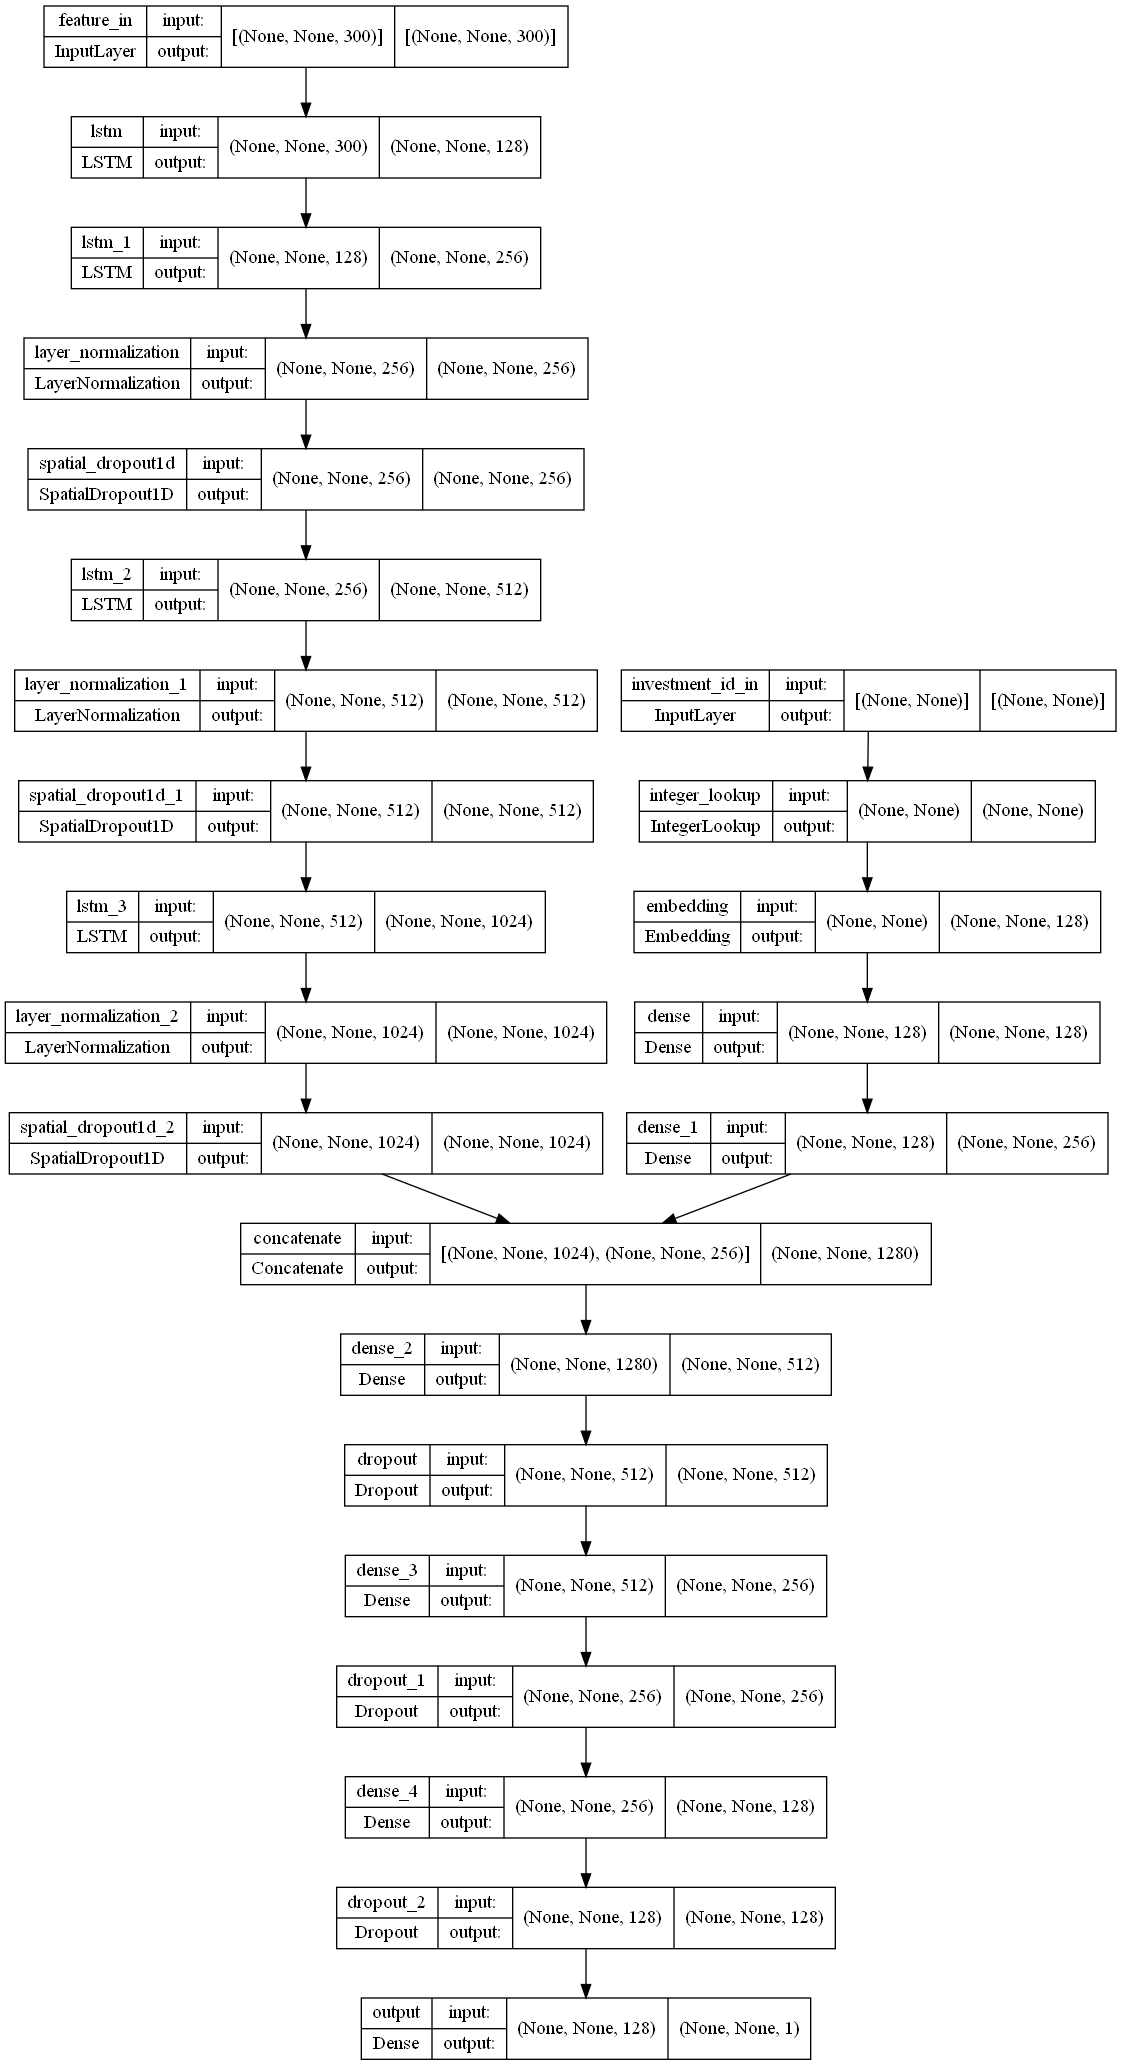

In [4]:
# Model
feature_in = Input(shape=(None, 300), name='feature_in', dtype=tf.float16)  # f0 to f299 = 300 features
investment_id_in = tf.keras.Input((None,), dtype=tf.uint16, name='investment_id_in')
investment_id_x = investment_id_lookup_layer(investment_id_in)
investment_id_x = Embedding(investment_id_size, 128, input_length=1)(investment_id_x)
investment_id_x = Dense(128, activation='swish')(investment_id_x)
investment_id_x = Dense(256, activation='swish')(investment_id_x)
# investment_id_x = Dense(512, activation='swish')(investment_id_x)


# xScaled = Lambda(lambda x: tf.math.multiply(x, 100), name='upscaler')(xIn)  # upscale to improve numerical stability
x = LSTM(128, return_sequences=True)(feature_in)
x = LSTM(256, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(512, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
# x = LSTM(1024, return_sequences=True)(x)
# x = concatenate([x, xIn])
x = LSTM(1024, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
x = concatenate([x, investment_id_x])
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
xOut = Dense(1, name='output')(x)


model = Model(inputs=[investment_id_in, feature_in], outputs=xOut)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics=[pearson_corr, 'mse', 'mae'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
# Train
valx_feat = tf.expand_dims(val[0].loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
valx_id = tf.expand_dims(val[0]['investment_id'].to_numpy(), axis=0)
valy = tf.expand_dims(val[0]['target'].to_numpy(), axis=0)
counter = 0
epoch = 15
print('Training...')
for i in range(epoch):
    print(f'Epoch {i+1}/{epoch}')
    for inv in train:
        counter += 1
        x_feat = tf.expand_dims(inv.loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
        x_id = tf.expand_dims(inv['investment_id'].to_numpy(), axis=0)
        y = tf.expand_dims(inv['target'].to_numpy(), axis=0)
        verbose = 1 if counter % 100 == 0 else 0  # print every 100 step
        model.fit({'investment_id_in': x_id, 'feature_in': x_feat}, y, validation_data=({'investment_id_in': valx_id, 'feature_in': valx_feat}, valy), epochs=1, batch_size=16, verbose=verbose)

print('Evaluating...')
eval_result = []
for inv in val:
    x_feat = tf.expand_dims(inv.loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
    x_id = tf.expand_dims(inv['investment_id'].to_numpy(), axis=0)
    y = tf.expand_dims(inv['target'].to_numpy(), axis=0)
    eval_result.append(model.evaluate({'investment_id_in': x_id, 'feature_in': x_feat}, y, verbose=1))

# y_pred = model.predict(valx)

Training...
Epoch 1/15
1/1 [==============================] - 0s 59ms/step - loss: 0.6724 - pearson_corr: 0.3409 - mse: 0.6726 - mae: 0.6508 - val_loss: 0.1628 - val_pearson_corr: 0.1022 - val_mse: 0.1628 - val_mae: 0.3499
Epoch 2/15
1/1 [==============================] - 0s 64ms/step - loss: 0.1077 - pearson_corr: 0.4057 - mse: 0.1078 - mae: 0.2677 - val_loss: 0.1764 - val_pearson_corr: 0.4942 - val_mse: 0.1764 - val_mae: 0.3638
Epoch 3/15
1/1 [==============================] - 0s 56ms/step - loss: 0.5703 - pearson_corr: 0.1505 - mse: 0.5702 - mae: 0.5113 - val_loss: 0.1382 - val_pearson_corr: 0.5682 - val_mse: 0.1383 - val_mae: 0.3265
Epoch 4/15
1/1 [==============================] - 0s 57ms/step - loss: 0.2050 - pearson_corr: 0.0037 - mse: 0.2049 - mae: 0.3777 - val_loss: 0.1432 - val_pearson_corr: 0.5491 - val_mse: 0.1431 - val_mae: 0.3307
Epoch 5/15
1/1 [==============================] - 0s 62ms/step - loss: 1.1250 - pearson_corr: 0.0961 - mse: 1.1252 - mae: 0.9269 - val_loss: 0.2

In [7]:
import statistics
print(f'Mean: {statistics.mean([i[0] for i in eval_result])}')

Mean: 0.9328488198472706


In [8]:
model.save('mean val 0.9328')

INFO:tensorflow:Assets written to: mean val 0.9328\assets


INFO:tensorflow:Assets written to: mean val 0.9328\assets


In [15]:
from ubiquantEmulator import TimeSeriesAPI
model = load_model('mean val 0.9328', custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_train = TimeSeriesAPI(test[test["investment_id"] < 100][:100])
for n, (train_df, sample_prediction_df) in enumerate(iter_train):
    pred = []
    for index, row in train_df.iterrows():
        x_feat = tf.expand_dims(tf.expand_dims(np.asarray(row.loc['f_0':'f_299']).astype('float32'), axis=0), axis=0)
        x_id = tf.expand_dims(tf.expand_dims(np.asarray(row['investment_id']).astype('uint16'), axis=0), axis=0)
        print(tf.squeeze(model.predict({'investment_id_in': x_id, 'feature_in': x_feat})).numpy())
        pred += [tf.squeeze(model.predict({'investment_id_in': x_id, 'feature_in': x_feat})).numpy()]
    # make inference
    sample_prediction_df.assign(target=pd.Series(pred))
    iter_train.predict(sample_prediction_df)

-0.2524
-0.542
0.3572
-0.3713
-0.3865
0.771
-0.3628
-0.2925
-0.1884
-0.3743
-0.545
0.0869
0.6484
-0.4954
-0.824
-0.0621
-0.615
-0.12244
-0.4587
0.3232
0.5166
-0.4749
0.1552
0.3574
0.01419
-0.2227
-0.0529
-0.27
0.10767
0.0328
-0.1681
-0.4485
0.1597
-0.3972
0.868
-0.405
0.708
-0.1681
-0.327
0.5015
-0.1976
-0.00583
-0.2666
0.2927
-0.217
-0.0935
-0.2422
0.7407
-0.2207
-0.8604
-0.44
-0.4534
-0.3093
-0.1614
0.9136
-1.184
-1.046
-0.1631
0.0481
-0.0934
-0.2656
-0.0779
-0.1381
-0.4202
0.754
-0.2698
-0.0604
0.02148
-0.3928
-0.319
0.0796
0.5747
-0.4377
-0.3413
-0.4353
-0.3867
0.02449
-0.5073
0.3997
0.231
-0.1023
0.1749
0.363
-0.5366
-0.341
-0.0557
-0.1992
0.0785
-0.1934
-0.74
0.11096
-0.4963
1.171
-0.4094
0.4553
-0.1918
-0.3843
0.4612
-0.1617
0.02733


In [ ]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['target'] = 0  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions